In [15]:
#!/usr/bin/env python3

# add the path to the folder above, hardcoded
import sys
pathhere = "/home/luke/mymujoco/rl/"
sys.path.insert(0, pathhere)

from env.MjEnv import MjEnv
import numpy as np
from matplotlib import pyplot as plt
import pickle

# global variables
max_force = 4
set_name = "set6_testing"

# create and prepare the mujoco instance
mj = MjEnv(noload=True)
mj.testing_xmls = 0
mj.task_reload_chance = -1

# specify finger dimensions
mj.params.finger_thickness = 0.9e-3
mj.load_finger_width = 28e-3

# specify which segments to test
# segments = [5, 6, 7, 8, 9, 10, 15, 20, 25, 30]
# segments = [5, 6, 7, 8, 9, 10]
# segments = [5, 10, 15]
segments = list(range(3, 31))

print(f"Finger thickness is {mj.params.finger_thickness * 1000:.1f} mm")
print(f"Finger width is {mj.load_finger_width * 1000:.1f} mm")

Finger thickness is 0.9 mm
Finger width is 28.0 mm


In [16]:
# will we recalculate data
get_data = False
get_converged = False

# 0=point end load, 1=UDL, 2=point end moment
force_style = 2

if not get_data or not get_converged:

  default_name_style = "pickle_thickness_{0:.1f}mm_width_{1:.0f}mm"

  if force_style == 0: default_name_style += "_PL.pickle"
  elif force_style == 1: default_name_style += "_UDL.pickle"
  elif force_style == 2: default_name_style += "_EM.pickle"
  else: raise RuntimeError("no matching force_style")

  with open(default_name_style.format(0.8, 28), "rb") as f:
    [d_0p8_28_model_default, d_0p8_28_tuned_default] = pickle.load(f)

  with open(default_name_style.format(0.9, 24), "rb") as f:
    [d_0p9_24_model_default, d_0p9_24_tuned_default] = pickle.load(f)

  with open(default_name_style.format(0.9, 28), "rb") as f:
    [d_0p9_28_model_default, d_0p9_28_tuned_default] = pickle.load(f)

  with open(default_name_style.format(1.0, 24), "rb") as f:
    [d_1p0_24_model_default, d_1p0_24_tuned_default] = pickle.load(f)

  with open(default_name_style.format(1.0, 28), "rb") as f:
    [d_1p0_28_model_default, d_1p0_28_tuned_default] = pickle.load(f)

  # load some existing data defaults, can be overwritten
  if (abs(mj.params.finger_thickness * 1000 - 0.8) < 1e-5 and
     abs(mj.load_finger_width * 1000 - 28) < 1e-5):
    data = d_0p8_28_model_default
    data_converged = d_0p8_28_tuned_default

  elif (abs(mj.params.finger_thickness * 1000 - 0.9) < 1e-5 and
     abs(mj.load_finger_width * 1000 - 24) < 1e-5):
    data = d_0p9_24_model_default
    data_converged = d_0p9_24_tuned_default

  elif (abs(mj.params.finger_thickness * 1000 - 0.9) < 1e-5 and
     abs(mj.load_finger_width * 1000 - 28) < 1e-5):
    data = d_0p9_28_model_default
    data_converged = d_0p9_28_tuned_default

  elif (abs(mj.params.finger_thickness * 1000 - 1.0) < 1e-5 and
     abs(mj.load_finger_width * 1000 - 24) < 1e-5):
    data = d_1p0_24_model_default
    data_converged = d_1p0_24_tuned_default

  elif (abs(mj.params.finger_thickness * 1000 - 1.0) < 1e-5 and
     abs(mj.load_finger_width * 1000 - 28) < 1e-5):
    data = d_1p0_28_model_default
    data_converged = d_1p0_28_tuned_default

  else:
    raise RuntimeError("no finger thickness matches")


In [17]:
# OLD, this FEA data uses newtons not grams

# from FEA_data import FEA_1N, FEA_2N, FEA_3N, FEA_4N, FEA_5N

# # this data uses FORCES, it is [1N, 2N, 3N, 4N, 5N]
# FEA_xy = [
#   1e-3 * np.array(FEA_1N),
#   1e-3 * np.array(FEA_2N),
#   1e-3 * np.array(FEA_3N),
#   1e-3 * np.array(FEA_4N),
#   1e-3 * np.array(FEA_5N)]

In [18]:
from FEA_data import fea_data

# this data uses MASSES, it is [100g, 200g, 300g, 400g]
FEA_xy2 = [ 
  fea_data[1],
  fea_data[2],
  fea_data[3],
  fea_data[4]
]

In [19]:
from real_data import real_data

# this data uses MASSES, it is [100g, 200g, 300g, 400g]
REAL_xy = [
  real_data[2],
  real_data[4],
  real_data[6],
  real_data[8]
]

In [20]:
def run_curve_data(mjenv, segments, converge_to=None, converge_target_accuracy=5e-4, auto=True, stiffness=-7.5,
                   force_style=0):
  """
  This function returns a data structure containing curve validation data for
  a given mjenv across a given list of segments eg [5, 10, 15, 20]
  """

  data = []

  # turn on automatic finding of highest stable timestep
  mjenv.mj.set.auto_set_timestep = auto

  # turn off automatic finding of calibrations as they are not needed
  mjenv.mj.set.auto_calibrate_gauges = False

  # set finger stiffness style (-7.5=final theory, -100=hardcoded real, -101=hardcoded theory)
  mjenv.mj.set.finger_stiffness = stiffness

  if converge_to is not None: 
    stiffness_code_string = ""
    loops_code_string = "std::vector<int> loops { "
    errors_code_string = "std::vector<float> errors { "

  # loop through each object set and gather data
  for N in segments:

    mjenv.load(object_set_name=set_name, num_segments=N)
    mjenv.reset(hard=True)

    # if we are converging stiffness before recording data
    if converge_to is not None:

      # # add safety cushion to timestep
      # mjenv.mj.set.mujoco_timestep *= 0.8
      # mjenv.reset()

      if isinstance(converge_to, (int, float)):
        # if given an int/float value converge to the theory point load deflection curve for this value
        print(f"Curve convergence to theory deflection at {converge_to:.2f} newtons, target_accuracy is {converge_target_accuracy * 100}%, N =", N, "\t N in sim is", mjenv.mj.get_N(), flush=True)
        info = mjenv.mj.numerical_stiffness_converge(converge_to, converge_target_accuracy) # converge to 300g, basic theory curve
      else:
        # if given a numpy array of curve values, converge to this curve
        print(f"Curve convergence to given curve, N =", N, "\t N in sim is", mjenv.mj.get_N(), flush=True)
        info = mjenv.mj.numerical_stiffness_converge(converge_to[:,0], converge_to[:,1], converge_target_accuracy) # eg converge on real data

      vec_str = ""
      vec = mjenv.mj.get_finger_stiffnesses()
      for v in vec: vec_str += f"{v:.2f}, "
      code_stiffness = "std::vector<float> N{0} {{ {1} }};\n".format(N, vec_str[:-2]) # trim ', '

      split = info.replace(",", "=").split("=")
      loops = int(split[1])
      error = float(split[3])
      
      # save the code snippets
      stiffness_code_string += code_stiffness
      loops_code_string += str(loops) + ", "
      errors_code_string += str(error) + ", "

      print("Convergence finished with:", info, flush=True)
      print("Stiffness vector is:", mjenv.mj.get_finger_stiffnesses(), flush=True)

    else:
      # do not do any convergence
      print("Curve validation running for N =", N, "\t N in sim is", mjenv.mj.get_N(), flush=True)

    print_out = False
    finger_data = mjenv.mj.curve_validation_regime(print_out, force_style)
    data.append(finger_data)

  if converge_to is not None:
    print("\n" + stiffness_code_string)
    print(loops_code_string[:-2] + " };")
    print(errors_code_string[:-2] + " };")

  print(f"force style was {force_style}")

  return data

# set finger stiffness algorithm
finger_stiffness = -7.5 # finalised theory result

auto_timestep = True
converge = None
accuracy = None

# # uncomment to recalculate stiffnesses and converge
# converge = 3 * 0.981 # grams force, not newtons
# accuracy = 5e-4
# finger_stiffness = -7.5 # finalised theory as intial guess

if get_data:
  data = run_curve_data(mj, segments, auto=auto_timestep, stiffness=finger_stiffness, converge_to=converge, 
  converge_target_accuracy=accuracy, force_style=force_style)

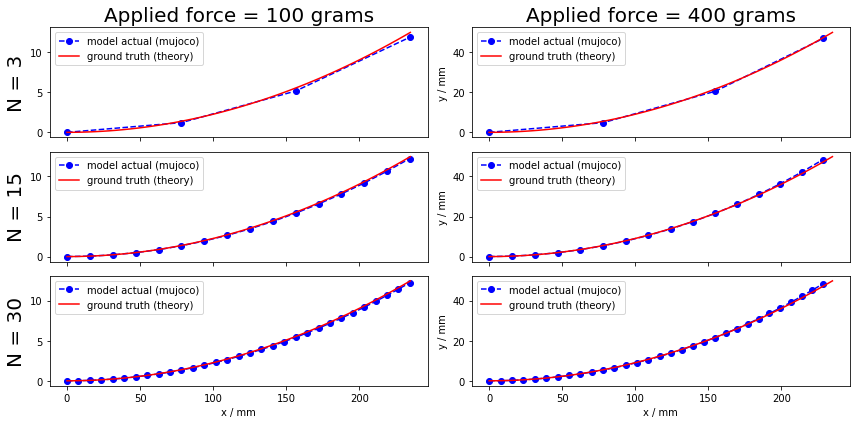

In [21]:
def plot_deflection(data, entries=None, pred=False, theory=True, FEA=None, real=None):
  """
  Plot the XY beam deflection curves
  
  """

  num_sets = len(data)

  # process the data and plot it
  if entries is None:
    entries = [0, (num_sets // 2) - 2, -1]
  elif entries == "all":
    entries = list(range(num_sets))
  plot_height = len(entries)

  forces = list(range(1, max_force + 1))
  forces = [1, max_force]

  plot_width = len(forces)

  fig, axs = plt.subplots(len(entries), len(forces), sharex=True, sharey=False)

  for i, force in enumerate(forces):
    for j, ind in enumerate(entries):

      # lets start by plotting a basic example
      x =        1e3 * np.array(data[ind].entries[force - 1].f1.x)
      y =        1e3 * np.array(data[ind].entries[force - 1].f1.y)
      pred_x =   1e3 * np.array(data[ind].entries[force - 1].f1.pred_x)
      pred_y =   1e3 * np.array(data[ind].entries[force - 1].f1.pred_y)
      theory_x = 1e3 * np.array(data[ind].entries[force - 1].f1.theory_x_curve)
      theory_y = 1e3 * np.array(data[ind].entries[force - 1].f1.theory_y_curve)

      if pred is True:
        axs[j][i].plot(pred_x,   pred_y,   "r--*", label="model predictions")

      # always plot the mujoco curve
      axs[j][i].plot(x,        y,        "b--o",  label="model actual (mujoco)")

      if theory is True:
        axs[j][i].plot(theory_x, theory_y, "r",    label="ground truth (theory)")
      if FEA is not None:
        axs[j][i].plot(FEA[force - 1][:,0], FEA[force - 1][:,1], label="FEA")
      if real is not None:
        axs[j][i].plot(real[force - 1][:,0], real[force - 1][:,1], label="Real")

      # add error labelling, not currently wanted
      # axs[j][i].text(0.005, data[ind].entries[force - 1].f1.theory_y[-1] * 0.4,
      #   f"mujoco stddev wrt model= {1000 * data[ind].entries[force - 1].f1.error.std_y_wrt_pred_y:.2f}mm\n" +
      #   f"mujoco stddev wrt theory = {1000 * data[ind].entries[force - 1].f1.error.std_y_wrt_theory_y:.2f}mm\n" +
      #   f"model stddev wrt theory = {1000 * data[ind].entries[force - 1].f1.error.std_y_pred_wrt_theory_y:.2f}mm",
      #   fontsize=14)

      # adjusting axis settings
      # axs[j][i].axis("equal")
      axs[j][i].legend(loc="upper left")
      # axs[j][i].set(ylim=(0, 60e-3))
      
      # add axis labels
      axs[j][i].set(ylabel="y / mm")
      if j == len(entries) - 1:
        axs[j][i].set(xlabel="x / mm")
      if j == 0:
        axs[j][i].set_title(f"Applied force = {force * 100} grams", fontsize=20)
        # axs[j][i].set_title(f"{force * 100} grams", fontsize=20)
      if i == 0:
        temp_N = len(data[ind].entries[force - 1].f1.y) - 1
        axs[j][i].set_ylabel(f"N = {temp_N}", fontsize=20, rotation=90)

  tile_height = 2
  tile_width = 6
  fig.set_size_inches(tile_width*plot_width, tile_height*plot_height)

  # potential size overrides
  # fig.set_size_inches(35, 25)
  # fig.set_size_inches(20, 15)
  # fig.set_size_inches(12, 5)

  fig.tight_layout()

# now run the above function and plot the deflection curves
plot_deflection(data, entries=None, pred=False, theory=True)

In [22]:
# print("theory x is", theory_x * 1000)
# print("theory y is", theory_y * 1000)

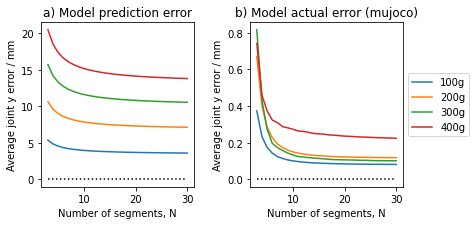

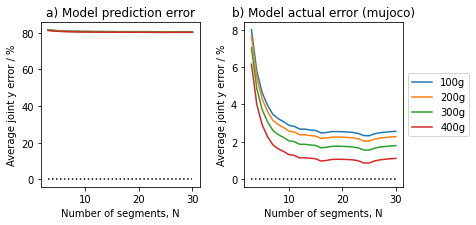

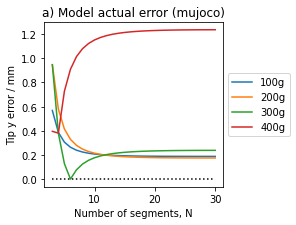

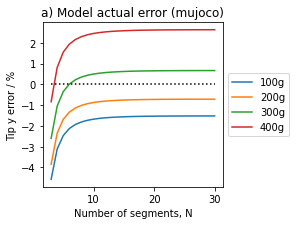

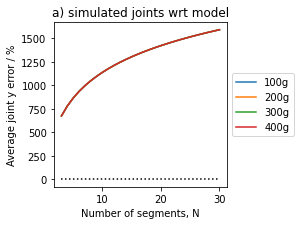

In [29]:
def plot_errors(datainput, plot=None, y_vs_pred=True, y_vs_theory=True, pred_vs_theory=True,
                percent=False, j_vs_pred=False, absolute_error=True, plot_avg=False,
                sharey=False, plot_zero=True, all_loads_plot=False, titles_override=None):
  """
  Plot an error curve
  """

  num_plots = y_vs_pred + y_vs_theory + pred_vs_theory + j_vs_pred
  fig_labels = ["a) ", "b) ", "c) ", "d) ", "e) "]

  if all_loads_plot: num_plots += len(datainput) - 1

  fig, axs = plt.subplots(1, num_plots, sharey=sharey)

  if num_plots == 1:
    axs = [axs]

  p = -1 # plot counter
  axis_label = True

  if all_loads_plot: loop_over = datainput
  else: loop_over = [datainput]

  for data in loop_over:

    num_sets = len(data)
    labels = ["100g", "200g", "300g", "400g"]
    if plot_avg: labels += ["avg."]
    unit = "mm" if not percent else "%"

    # redefine forces and entries to include all, otherwise index error
    forces = list(range(1, max_force + 1))

    # get std deviation data
    y_wrt_pred_y = np.zeros((num_sets, len(forces)))
    y_wrt_theory_y = np.zeros((num_sets, len(forces)))
    y_pred_wrt_theory_y = np.zeros((num_sets, len(forces)))
    j_wrt_pred_j = np.zeros((num_sets, len(forces)))

    sets_N = []

    for i in range(num_sets):

      sets_N.append(len(data[i].entries[0].f1.y) - 1)

      for j in range(len(forces)):

        if plot == "joints":
          # joint error std dev in millimeters
          if percent:
            y_wrt_pred_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_wrt_pred_y_percent * 100
            y_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_wrt_theory_y_percent * 100
            y_pred_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_pred_wrt_theory_y_percent * 100
            j_wrt_pred_j[i, j] = data[i].entries[forces[j] - 1].f1.error.j_wrt_pred_j_percent * 100
          else:
            y_wrt_pred_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_wrt_pred_y * 1000
            y_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_wrt_theory_y * 1000
            y_pred_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_pred_wrt_theory_y * 1000
            j_wrt_pred_j[i, j] = data[i].entries[forces[j] - 1].f1.error.j_wrt_pred_j * 1000
        elif plot == "tip":
          # Tip y error percentage
          if percent:
            y_wrt_pred_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_tip_wrt_pred_y_percent * 100
            y_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_tip_wrt_theory_y_percent * 100
            y_pred_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_pred_tip_wrt_theory_y_percent * 100
          else:
            y_wrt_pred_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_tip_wrt_pred_y * 1000
            y_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_tip_wrt_theory_y * 1000
            y_pred_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_pred_tip_wrt_theory_y * 1000

    # do we convert to absolute error
    if absolute_error:
      y_wrt_pred_y = np.abs(y_wrt_pred_y)
      y_wrt_theory_y = np.abs(y_wrt_theory_y)
      y_pred_wrt_theory_y = np.abs(y_pred_wrt_theory_y)
      j_wrt_pred_j = np.abs(j_wrt_pred_j)
    
    # get the mean error
    mean_y_wrt_pred_y = np.mean(y_wrt_pred_y, axis=1)
    mean_y_wrt_theory_y = np.mean(y_wrt_theory_y, axis=1)
    mean_y_pred_wrt_theory_y = np.mean(y_pred_wrt_theory_y, axis=1)
    mean_j_wrt_pred_j = np.mean(j_wrt_pred_j, axis=1)

    lines = '-'
    avg = '--' # line style for average of all other lines
    zero = 'k:'

    if pred_vs_theory:
      p += 1
      axs[p].plot(np.array(sets_N), y_pred_wrt_theory_y, lines)
      if plot_avg: axs[p].plot(np.array(sets_N), mean_y_pred_wrt_theory_y, avg)
      if plot_zero: axs[p].plot(np.array(sets_N), np.zeros(len(sets_N)), zero)
      axs[p].set_title(fig_labels[p] + ("Model prediction error" if titles_override is None else titles_override[p]))
      axs[p].set(xlabel="Number of segments, N")
      if axis_label:
        if plot == "joints": axs[p].set(ylabel=f"Average joint y error / {unit}")
        if plot == "tip": axs[p].set(ylabel=f"Tip y error / {unit}")
        if sharey: axis_label = False

    if y_vs_pred:
      p += 1
      axs[p].plot(np.array(sets_N), y_wrt_pred_y, lines)
      if plot_avg: axs[p].plot(np.array(sets_N), mean_y_wrt_pred_y, avg)
      if plot_zero: axs[p].plot(np.array(sets_N), np.zeros(len(sets_N)), zero)
      axs[p].set_title(fig_labels[p] + ("Actual error wrt prediction" if titles_override is None else titles_override[p]))
      axs[p].set(xlabel="Number of segments, N")
      if axis_label:
        if plot == "joints": axs[p].set(ylabel=f"Average joint y error / {unit}")
        if plot == "tip": axs[p].set(ylabel=f"Tip y error / {unit}")
        if sharey: axis_label = False

    if y_vs_theory:
      p += 1
      axs[p].plot(np.array(sets_N), y_wrt_theory_y, lines)
      if plot_avg: axs[p].plot(np.array(sets_N), mean_y_wrt_theory_y, avg)
      if plot_zero: axs[p].plot(np.array(sets_N), np.zeros(len(sets_N)), zero)
      axs[p].set_title(fig_labels[p] + ("Model actual error (mujoco)" if titles_override is None else titles_override[p]))
      axs[p].set(xlabel="Number of segments, N")
      if axis_label:
        if plot == "joints": axs[p].set(ylabel=f"Average joint y error / {unit}")
        if plot == "tip": axs[p].set(ylabel=f"Tip y error / {unit}")
        if sharey: axis_label = False

    if j_vs_pred and plot == "joints":
      p += 1
      axs[p].plot(np.array(sets_N), j_wrt_pred_j, lines)
      if plot_avg: axs[p].plot(np.array(sets_N), mean_j_wrt_pred_j, avg)
      if plot_zero: axs[p].plot(np.array(sets_N), np.zeros(len(sets_N)), zero)
      axs[p].set_title(fig_labels[p] + ("simulated joints wrt model" if titles_override is None else titles_override[p]))
      axs[p].set(xlabel="Number of segments, N")
      if axis_label:
        if plot == "joints": axs[p].set(ylabel=f"Average joint y error / {unit}")
        if plot == "tip": axs[p].set(ylabel=f"Tip y error / {unit}")
        if sharey: axis_label = False

  # add legend and labels
  lines = axs[p].get_lines()
  plt.legend(iter(lines), labels, loc="center left", bbox_to_anchor=(1, 0.5))
  # if plot == "joints": axs[0].set(ylabel=f"Average joint y error / {unit}", xlabel="Number of segments, N")
  # if plot == "tip": axs[0].set(ylabel=f"Tip y error / {unit}", xlabel="Number of segments, N")
  # fig.suptitle("Joint displacement error against number of segments, N", fontsize=14)
  fig.tight_layout()
  # fig.subplots_adjust(top=0.8)

  fig.set_size_inches(3.5*num_plots, 3)

  return

# run the above plotting function
plot_errors(data, plot="joints", y_vs_pred=False, y_vs_theory=True, pred_vs_theory=True, percent=False)
plot_errors(data, plot="joints", y_vs_pred=False, y_vs_theory=True, pred_vs_theory=True, percent=True)
plot_errors(data, plot="tip", y_vs_pred=False, y_vs_theory=True, pred_vs_theory=False, percent=False, sharey=True)
plot_errors(data, plot="tip", y_vs_pred=False, y_vs_theory=True, pred_vs_theory=False, percent=True, 
            sharey=True, absolute_error=False, plot_avg=False)

plot_errors(data, plot="joints", y_vs_pred=False, y_vs_theory=False, pred_vs_theory=False, j_vs_pred=True, percent=True)


In [24]:
auto_timestep = True

# uncomment to recalculate stiffnesses and converge
converge_force = 3 * 0.981 # 300 grams force
finger_stiffness = -7.5 # finalised theory as intial guess
accuracy = 5e-4

# uncomment to use hardcoded stiffness values
converge_force = None
finger_stiffness = -101 # hardcoded theory predictions convergence
accuracy = None

if get_converged:
  data_converged = run_curve_data(mj, segments, converge_to=converge_force, auto=auto_timestep, 
                                  stiffness=finger_stiffness, force_style=force_style)

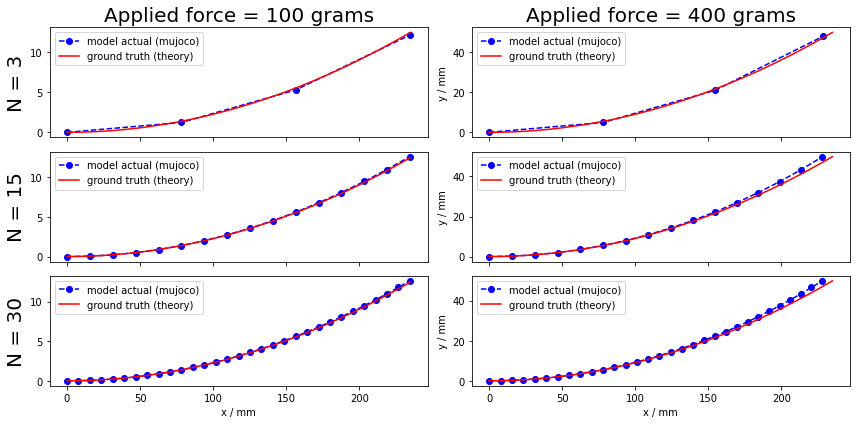

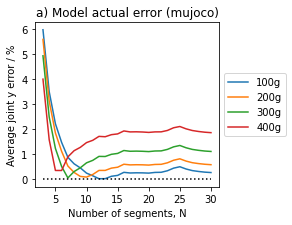

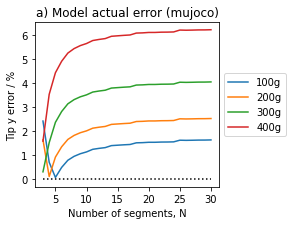

In [25]:
# generate plots with converged data
plot_deflection(data_converged, entries=None, pred=False, theory=True) #, FEA=FEA_xy2, real=REAL_xy)
plot_errors(data_converged, plot="joints", y_vs_pred=False, y_vs_theory=True, pred_vs_theory=False, percent=True)
plot_errors(data_converged, plot="tip", y_vs_pred=False, y_vs_theory=True, pred_vs_theory=False, percent=True)

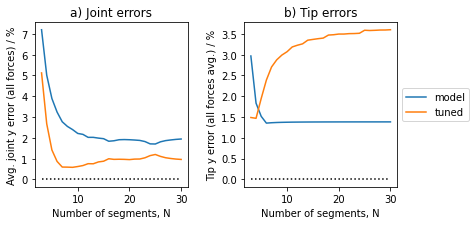

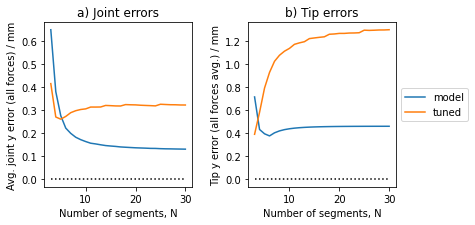

In [26]:
def plot_avg_errors(data_array, labels, titles=None, joint_plot=True, tip_plot=True, joint_percent=False,
                    tip_percent=True, difference_plot=False, sharey=False, prediction_plot=False,
                    absolute_error=True, multiplot_num=3, max_plot=False, max_error=False):
  """
  Plot an error curve
  """

  num_plots = prediction_plot + joint_plot + tip_plot + difference_plot + bool(max_plot)
  fig_labels = ["a) ", "b) ", "c) ", "d) ", "e) "]

  fig, axs = plt.subplots(1, num_plots, sharey=sharey)

  if num_plots == 1:
    axs = [axs]

  if titles is None:
    titles = []
    for i in range(prediction_plot): titles.append("Prediction errors")
    for i in range(joint_plot): titles.append("Joint errors")
    for i in range(tip_plot): titles.append("Tip errors")
    for i in range(difference_plot): titles.append("Improvement from tuning")
    if max_plot: titles.append("Maximum error")
    
  num_sets = len(data_array[0])
  joint_unit = "%" if joint_percent else "mm"
  tip_unit = "%" if tip_percent else "mm"

  for k in range(len(data_array)):
    if len(data_array[k]) != num_sets:
      raise RuntimeError("data arrays have different sizes")

  # redefine forces and entries to include all, otherwise index error
  forces = list(range(1, max_force + 1))

  # get std deviation data
  joint_vec = []
  tip_vec = []
  for i in range(len(data_array)):
    joint_vec.append([np.zeros((num_sets, len(forces))) for j in range(3)])
    tip_vec.append([np.zeros((num_sets, len(forces))) for j in range(3)])

  sets_N = []

  for i in range(num_sets):

    sets_N.append(len(data_array[k][i].entries[0].f1.y) - 1)

    for j in range(len(forces)):
      for k in range(len(data_array)):

        # joint error std dev in millimeters
        if joint_percent:
          joint_vec[k][0][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_wrt_pred_y_percent * 100
          joint_vec[k][1][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_wrt_theory_y_percent * 100
          joint_vec[k][2][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_pred_wrt_theory_y_percent * 100
        else:
          joint_vec[k][0][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_wrt_pred_y * 1000
          joint_vec[k][1][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_wrt_theory_y * 1000
          joint_vec[k][2][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_pred_wrt_theory_y * 1000

        # Tip y error percentage
        if tip_percent:
          tip_vec[k][0][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_tip_wrt_pred_y_percent * 100
          tip_vec[k][1][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_tip_wrt_theory_y_percent * 100
          tip_vec[k][2][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_pred_tip_wrt_theory_y_percent * 100
        else:
          tip_vec[k][0][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_tip_wrt_pred_y * 1000
          tip_vec[k][1][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_tip_wrt_theory_y * 1000
          tip_vec[k][2][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_pred_tip_wrt_theory_y * 1000

  # convert to absolute errors
  if absolute_error:
    for i in range(len(joint_vec)):
      joint_vec[i] = np.abs(joint_vec[i])
    for i in range(len(tip_vec)):
      tip_vec[i] = np.abs(tip_vec[i])

  # get the mean error
  joint_means = []
  tip_means = []

  for k in range(len(data_array)):
    if max_error:
      joint_means.append([
        np.max(joint_vec[k][0], axis=1), # y_wrt_pred_y
        np.max(joint_vec[k][1], axis=1), # y_wrt_theory_y
        np.max(joint_vec[k][2], axis=1)  # y_pred_wrt_theory_y
      ])
      tip_means.append([
        np.max(tip_vec[k][0], axis=1), # y_wrt_pred_y
        np.max(tip_vec[k][1], axis=1), # y_wrt_theory_y
        np.max(tip_vec[k][2], axis=1)  # y_pred_wrt_theory_y
      ])

    else: # take mean
      joint_means.append([
        np.mean(joint_vec[k][0], axis=1), # y_wrt_pred_y
        np.mean(joint_vec[k][1], axis=1), # y_wrt_theory_y
        np.mean(joint_vec[k][2], axis=1)  # y_pred_wrt_theory_y
      ])
      tip_means.append([
        np.mean(tip_vec[k][0], axis=1), # y_wrt_pred_y
        np.mean(tip_vec[k][1], axis=1), # y_wrt_theory_y
        np.mean(tip_vec[k][2], axis=1)  # y_pred_wrt_theory_y
      ])

  p = -1

  avg = '--' # line style for average of all other lines
  zero = "k:"
  zero_value = 0.0
  max_lines = len(data_array)

  # multiplots require the number of lines per plot to be given
  if joint_plot > 1 or tip_plot > 1 or difference_plot > 1 or max_plot > 1:
    if len(data_array) % multiplot_num == 0 and len(data_array) > multiplot_num:
      max_lines = multiplot_num  

  # predictions plot
  for i in range(prediction_plot):
    p += 1
    for k in range(max_lines * i, max_lines * (i + 1)):
      axs[p].plot(np.array(sets_N), tip_means[k][2])
    axs[p].plot(np.array(sets_N), np.ones(len(sets_N)) * zero_value, zero)
    axs[p].set_title(fig_labels[p] + titles[p])
    axs[p].set(xlabel="Number of segments, N")
    if not sharey or p == 0:
      axs[p].set(ylabel=f"Tip y error (all forces avg.) / {tip_unit}", xlabel="Number of segments, N")

  # joint plot
  for i in range(joint_plot):
    p += 1
    for k in range(max_lines * i, max_lines * (i + 1)):
      axs[p].plot(np.array(sets_N), joint_means[k][1])
    axs[p].plot(np.array(sets_N), np.ones(len(sets_N)) * zero_value, zero)
    axs[p].set_title(fig_labels[p] + titles[p])
    axs[p].set(xlabel="Number of segments, N")
    if not sharey or p == 0:
      axs[p].set(ylabel=f"Avg. joint y error (all forces) / {joint_unit}", xlabel="Number of segments, N")

  # tip plot
  for i in range(tip_plot):
    p += 1
    for k in range(max_lines * i, max_lines * (i + 1)):
      axs[p].plot(np.array(sets_N), tip_means[k][1])
    axs[p].plot(np.array(sets_N), np.ones(len(sets_N)) * zero_value, zero)
    axs[p].set_title(fig_labels[p] + titles[p])
    axs[p].set(xlabel="Number of segments, N")
    if not sharey or p == 0:
      if max_error: tip_title = f"Maximum tip y error / {tip_unit}"
      else: tip_title = f"Tip y error (all forces avg.) / {tip_unit}"
      axs[p].set(ylabel=tip_title, xlabel="Number of segments, N")

  # difference plot
  if difference_plot: 
    max_lines = int(len(data_array) * 0.5) # lines are in pairs
  for i in range(difference_plot):
    p += 1
    for k in range(max_lines * i, max_lines * (i + 1)):
      # we want if + to be error reduction, and - to be error increase
      # hence convert to abs first, this is abs error, then get difference
      diff = (np.abs(tip_means[k][1]) - np.abs(tip_means[k + max_lines][1]))
      axs[p].plot(np.array(sets_N), diff)
    axs[p].plot(np.array(sets_N), np.ones(len(sets_N)) * zero_value, zero)
    axs[p].set_title(fig_labels[p] + titles[p])
    axs[p].set(xlabel="Number of segments, N")
    if not sharey or p == 0:
      axs[p].set(ylabel=f"Error reduction / {tip_unit}", xlabel="Number of segments, N")

  # max plot
  if max_plot:
    p += 1
    load_avgs = [np.zeros(len(sets_N))] * 3
    load_vals = [np.zeros(len(sets_N))] * 3
    max_avgs = np.zeros(len(sets_N))
    max_vals = np.zeros(len(sets_N))
    # loop over all the tip error plots
    for i in range(max_plot):
      for k in range(max_lines * i, max_lines * (i + 1)):
        # axs[p].plot(np.array(sets_N), tip_means[k][1])
        load_vals[i] = np.fmax(load_vals[i], np.max(tip_vec[k][1], axis=1))
        load_avgs[i] = np.fmax(load_avgs[i], tip_means[k][1])
        max_vals = np.fmax(max_vals, np.max(tip_vec[k][1], axis=1))
        max_avgs = np.fmax(max_avgs, tip_means[k][1])

    top_str = "{:<5} {:<10} {:<10} {:<10}"
    row_str = "{:<5} {:<10.3f} {:<10.3f} {:<10.3f}"
    print(top_str.format(
      "N",
      "PLmax %",
      "UDL max %",
      "EM max %",
    ))
    # print_str = "Max error values are:\n"
    for x in range(len(max_vals)): 
      print(row_str.format(
        sets_N[x],
        np.max(load_vals[0][x]),
        np.max(load_vals[1][x]),
        np.max(load_vals[2][x]),
      ))
      
    #   print_str += f"N={sets_N[x]} Emax={max_vals[x]:.3f}% Eavg_max={max_avgs[x]:.3f}\n"
    # print(print_str)
      
    axs[p].plot(np.array(sets_N), max_vals)
    axs[p].plot(np.array(sets_N), max_avgs)
    axs[p].set_title(fig_labels[p] + titles[p])
    axs[p].set(xlabel="Number of segments, N")
    if not sharey or p == 0:
      axs[p].set(ylabel=f"Tip y error / {tip_unit}", xlabel="Number of segments, N")

  # add legend and labels
  lines = axs[p].get_lines()
  plt.legend(iter(lines), labels, loc="center left", bbox_to_anchor=(1, 0.5))
  # fig.suptitle("Joint displacement error against number of segments, N", fontsize=14)
  fig.tight_layout()
  # fig.subplots_adjust(top=0.8)

  fig.set_size_inches(3.5*num_plots, 3)

  return

avg_data = [data, data_converged]
labels = ["model", "tuned"]

plot_avg_errors(avg_data, labels, joint_percent=True, tip_percent=True)
plot_avg_errors(avg_data, labels, joint_percent=False, tip_percent=False)

In [27]:
# take care with overwrites
overwrite = False

name_style = "pickle_thickness_{0:.1f}mm_width_{1:.0f}mm_UDL.pickle"

if overwrite:
  thickness_mm = mj.params.finger_thickness * 1000
  width_mm = mj.params.finger_width * 1000
  with open(name_style.format(thickness_mm, width_mm), "wb") as f:
    pickle.dump([data, data_converged], f)

N     PLmax %    UDL max %  EM max %  
3     2.506      10.092     4.796     
4     2.776      7.212      4.706     
5     2.933      5.485      5.491     
6     3.034      4.335      5.895     
7     3.105      3.514      6.125     
8     3.158      2.899      6.265     
9     3.198      2.420      6.355     
10    3.230      2.038      6.415     
11    3.257      1.725      6.457     
12    3.278      1.464      6.485     
13    3.297      1.243      6.506     
14    3.312      1.054      6.521     
15    3.325      0.891      6.532     
16    3.337      0.759      6.540     
17    3.348      0.884      6.545     
18    3.356      0.995      6.549     
19    3.365      1.095      6.552     
20    3.372      1.184      6.554     
21    3.379      1.265      6.555     
22    3.385      1.339      6.556     
23    3.390      1.406      6.556     
24    3.395      1.468      6.556     
25    3.400      1.524      6.556     
26    3.404      1.577      6.556     
27    3.408      1.625   

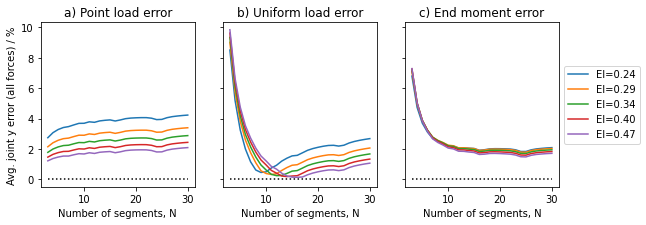

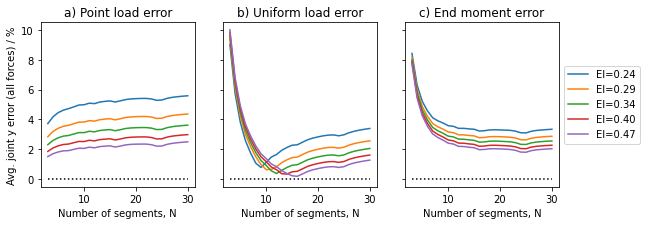

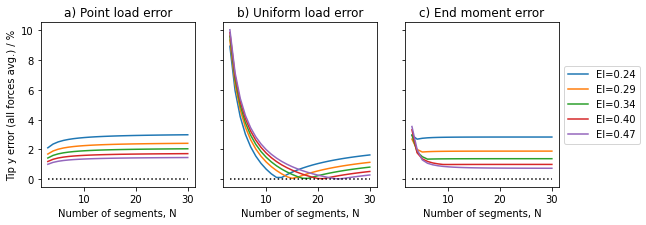

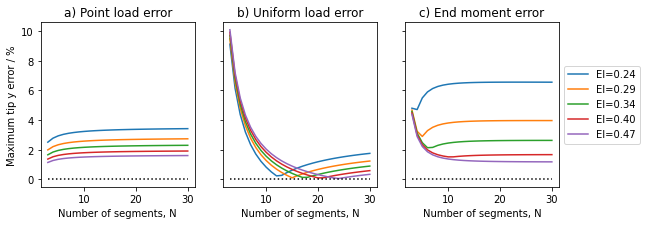

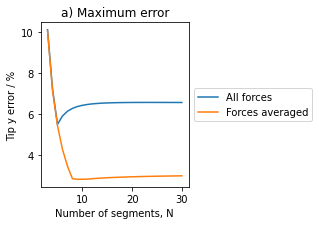

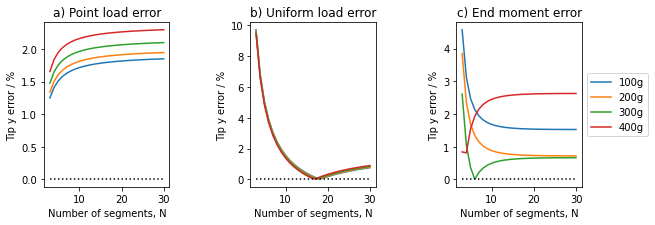

In [30]:
import pickle

multiplot = True

name_style = "pickle_thickness_{0:.1f}mm_width_{1:.0f}mm_PL.pickle"

if multiplot:

  with open(name_style.format(0.8, 28), "rb") as f:
    [d_0p8_28_model, d_0p8_28_tuned] = pickle.load(f)

  with open(name_style.format(0.9, 24), "rb") as f:
    [d_0p9_24_model, d_0p9_24_tuned] = pickle.load(f)

  with open(name_style.format(0.9, 28), "rb") as f:
    [d_0p9_28_model, d_0p9_28_tuned] = pickle.load(f)

  with open(name_style.format(1.0, 24), "rb") as f:
    [d_1p0_24_model, d_1p0_24_tuned] = pickle.load(f)

  with open(name_style.format(1.0, 28), "rb") as f:
    [d_1p0_28_model, d_1p0_28_tuned] = pickle.load(f)

  # UDL
  name_style = "pickle_thickness_{0:.1f}mm_width_{1:.0f}mm_UDL.pickle"
  
  with open(name_style.format(0.8, 28), "rb") as f:
    [d_0p8_28_model_UDL, d_0p8_28_tuned_UDL] = pickle.load(f)

  with open(name_style.format(0.9, 24), "rb") as f:
    [d_0p9_24_model_UDL, d_0p9_24_tuned_UDL] = pickle.load(f)

  with open(name_style.format(0.9, 28), "rb") as f:
    [d_0p9_28_model_UDL, d_0p9_28_tuned_UDL] = pickle.load(f)

  with open(name_style.format(1.0, 24), "rb") as f:
    [d_1p0_24_model_UDL, d_1p0_24_tuned_UDL] = pickle.load(f)

  with open(name_style.format(1.0, 28), "rb") as f:
    [d_1p0_28_model_UDL, d_1p0_28_tuned_UDL] = pickle.load(f)

  # pure moment
  name_style = "pickle_thickness_{0:.1f}mm_width_{1:.0f}mm_EM.pickle"
  
  with open(name_style.format(0.8, 28), "rb") as f:
    [d_0p8_28_model_EM, d_0p8_28_tuned_EM] = pickle.load(f)

  with open(name_style.format(0.9, 24), "rb") as f:
    [d_0p9_24_model_EM, d_0p9_24_tuned_EM] = pickle.load(f)

  with open(name_style.format(0.9, 28), "rb") as f:
    [d_0p9_28_model_EM, d_0p9_28_tuned_EM] = pickle.load(f)

  with open(name_style.format(1.0, 24), "rb") as f:
    [d_1p0_24_model_EM, d_1p0_24_tuned_EM] = pickle.load(f)

  with open(name_style.format(1.0, 28), "rb") as f:
    [d_1p0_28_model_EM, d_1p0_28_tuned_EM] = pickle.load(f)

  all_models = [
    d_0p8_28_model,
    d_0p9_24_model,
    d_0p9_28_model,
    d_1p0_24_model,
    d_1p0_28_model
  ]

  all_tuned = [ 
    d_0p8_28_tuned,
    d_0p9_24_tuned,
    d_0p9_28_tuned,
    d_1p0_24_tuned,
    d_1p0_28_tuned
  ]

  all_models_UDL = [
    d_0p8_28_model_UDL,
    d_0p9_24_model_UDL,
    d_0p9_28_model_UDL,
    d_1p0_24_model_UDL,
    d_1p0_28_model_UDL
  ]

  all_tuned_UDL = [ 
    d_0p8_28_tuned_UDL,
    d_0p9_24_tuned_UDL,
    d_0p9_28_tuned_UDL,
    d_1p0_24_tuned_UDL,
    d_1p0_28_tuned_UDL
  ]

  all_models_EM = [
    d_0p8_28_model_EM,
    d_0p9_24_model_EM,
    d_0p9_28_model_EM,
    d_1p0_24_model_EM,
    d_1p0_28_model_EM
  ]

  all_tuned_EM = [ 
    d_0p8_28_tuned_EM,
    d_0p9_24_tuned_EM,
    d_0p9_28_tuned_EM,
    d_1p0_24_tuned_EM,
    d_1p0_28_tuned_EM
  ]

  # diff = [
  #   d_0p8_model, d_0p8_tuned,
  #   d_0p9_model, d_0p9_tuned,
  #   d_1p0_model, d_1p0_tuned
  # ]

  model_labels = ["0.8-28 model", "0.9-24 model", "0.9-28 model", "1.0-24 model", "1.0-28 model"]
  tuned_labels = ["0.8-28 tuned", "0.9-24 tuned", "0.9-28 tuned", "1.0-24 tuned", "1.0-28 tuned"]
  # diff_labels = ["0.8mm", "0.9mm", "1.0mm"]
  diff_labels = ["0.8-28", "0.9-24", "0.9-28", "1.0-24", "1.0-28"]
  diff_labels = [
    "EI=0.24",
    "EI=0.29",
    "EI=0.34",
    "EI=0.40",
    "EI=0.47"
  ]

  model_vs_tuned_titles = [
    # "Prediction error",
    "Model actual error",
    "Tuned model actual error",
    # "Tuning error reduction"
  ]

  model_vs_UDL_titles = [
    "Point load error",
    "Uniform load error"
  ]

  tuned_vs_UDL_titles = [
    "Tuned point load error",
    "tuned uniform load error"
  ]

  all_loads_titles = [
    "Point load error",
    "Uniform load error",
    "End moment error",
    "Max error"
  ]
  # all three load conditions joints plot
  plot_avg_errors(all_models + all_models_UDL + all_models_EM, diff_labels, joint_percent=True, joint_plot=3,
                  tip_plot=False, titles=all_loads_titles, sharey=True, difference_plot=False,
                  prediction_plot=False, multiplot_num=len(all_models), absolute_error=True, max_plot=False)
  plot_avg_errors(all_models + all_models_UDL + all_models_EM, diff_labels, joint_percent=True, joint_plot=3,
                  tip_plot=False, titles=all_loads_titles, sharey=True, difference_plot=False,
                  prediction_plot=False, multiplot_num=len(all_models), absolute_error=True, max_error=True)
  # all three load conditions tip plot
  plot_avg_errors(all_models + all_models_UDL + all_models_EM, diff_labels, tip_percent=True, joint_plot=False,
                  tip_plot=3, titles=all_loads_titles, sharey=True, difference_plot=False,
                  prediction_plot=False, multiplot_num=len(all_models), absolute_error=True, max_plot=False)
  plot_avg_errors(all_models + all_models_UDL + all_models_EM, diff_labels, tip_percent=True, joint_plot=False,
                  tip_plot=3, titles=all_loads_titles, sharey=True, difference_plot=False,
                  prediction_plot=False, multiplot_num=len(all_models), absolute_error=True, max_error=True)
  # max plot
  max_labels = ["All forces", "Forces averaged"]
  plot_avg_errors(all_models + all_models_UDL + all_models_EM, max_labels, tip_percent=True, joint_plot=False,
                  tip_plot=False, titles=None, sharey=False, difference_plot=False,
                  prediction_plot=False, multiplot_num=len(all_models), absolute_error=True, max_plot=3)

  # # tuned model point load vs UDL
  # plot_avg_errors(all_tuned + all_tuned_UDL, diff_labels, tip_percent=True, joint_plot=False,
  #                 tip_plot=2, titles=tuned_vs_UDL_titles, sharey=True, difference_plot=False,
  #                 prediction_plot=False, multiplot_num=len(all_models), absolute_error=True)
  # plot_avg_errors([d_0p8_28_model, d_0p8_28_tuned], ["0.8mm model", "0.8mm tuned"], joint_percent=True, tip_percent=True)
  # plot_avg_errors([d_0p9_28_model, d_0p9_28_tuned], ["0.9mm model", "0.9mm tuned"], joint_percent=True, tip_percent=True)
  # plot_avg_errors([d_1p0_28_model, d_1p0_28_tuned], ["1.0mm model", "1.0mm tuned"], joint_percent=True, tip_percent=True)

# try multiple loads in one plot
ind = 2
datatest = [all_models[ind]] + [all_models_UDL[ind]] + [all_models_EM[ind]]
plot_errors(datatest, plot="tip", y_vs_pred=False, y_vs_theory=True, pred_vs_theory=False, percent=True, 
            sharey=False, absolute_error=True, plot_avg=False, all_loads_plot=True, titles_override=all_loads_titles)
